In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

In [2]:
!nvidia-smi

Fri Dec  8 01:04:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip '/content/drive/MyDrive/Pattern_Recog/lfw.zip' -d '/content/lfw_data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/lfw_data/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/lfw_data/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/lfw_data/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/lfw_data/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/lfw_data/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/lfw_data/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/lfw_data/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/lfw_data/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/lfw_data/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: /content/lfw_data/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: /

In [5]:
path = '/content/lfw_data/lfw'
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

torch.Size([250, 250, 3])


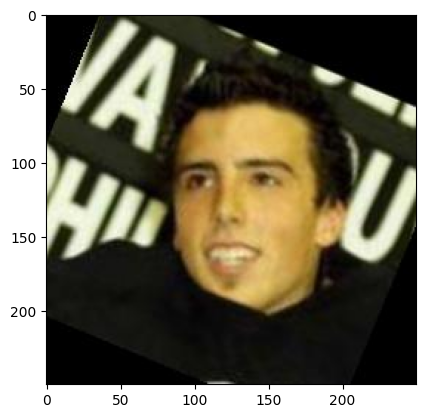

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.



Explanation of image data -
 The output torch.Size([250, 250, 3]) gives us the dimensions of a single image. Here's a breakdown of what each dimension represents:

First Dimension - Height (250):
This number represents the height of the image in pixels. In your case, each image has a height of 250 pixels. This is one of the spatial dimensions of the image.
Second Dimension - Width (250):
This number indicates the width of the image in pixels. Like the height, each image has a width of 250 pixels. This is the second spatial dimension of the image.
Third Dimension - Channels (3):
The number 3 here signifies the number of color channels in the image. For standard RGB (Red, Green, Blue) images, there are 3 channels, each representing a color intensity value at each pixel.
The first channel represents the intensity of Red color in each pixel.
The second channel represents the intensity of Green color.
The third channel represents the intensity of Blue color.
So, when you access a single data point (an image) from your DataLoader, it comes as a tensor with the shape [250, 250, 3], meaning it is a 250x250 pixel image with 3 color channels (RGB). Each pixel in the image can be represented by a triplet of values, each corresponding to the intensity of Red, Green, and Blue at that pixel location.

To visualize or further process these images, you'll often need to keep this dimensional structure in mind, especially if you're using libraries like Matplotlib for visualization or PyTorch for image-related computations and neural network training.


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [73]:
'''I tried traaining with this model that I desined first but the loss value after training was very high and
the image that was being generated was whitish and blurred so I observed that the image pixlet very crowded and caused uderfitting of the data points
import torch
import torch.nn as nn
import torch.nn.functional as F


class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.enc_bn4 = nn.BatchNorm2d(512)
        self.enc_conv5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)
        self.enc_bn5 = nn.BatchNorm2d(1024)

        # Decoder Layers
        self.dec_upsample1 = nn.Upsample(size=(16, 16), mode='bilinear', align_corners=True)
        self.dec_convtrans1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(512)
        self.dec_upsample2 = nn.Upsample(size=(62, 62), mode='bilinear', align_corners=True)
        self.dec_convtrans2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(256)
        self.dec_upsample3 = nn.Upsample(size=(125, 125), mode='bilinear', align_corners=True)
        self.dec_convtrans3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(128)
        self.dec_upsample4 = nn.Upsample(size=(250, 250), mode='bilinear', align_corners=True)
        self.dec_convtrans4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn4 = nn.BatchNorm2d(64)
        self.dec_convtrans5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.dec_bn5 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        x = F.relu(self.enc_bn4(self.enc_conv4(x)))
        x = F.relu(self.enc_bn5(self.enc_conv5(x)))
        return x

    def decoder(self, x):
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_bn1(self.dec_convtrans1(x)))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_bn2(self.dec_convtrans2(x)))
        x = self.dec_upsample3(x)
        x = F.relu(self.dec_bn3(self.dec_convtrans3(x)))
        x = self.dec_upsample4(x)
        x = F.relu(self.dec_bn4(self.dec_convtrans4(x)))
        x = F.relu(self.dec_bn5(self.dec_convtrans5(x)))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x'''


In [7]:
'''this is the final model that I designed here I have used bilinear mode that is specifically used in image encoding and
is a better choice than the nearest mode'''
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)

        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='bilinear')
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='bilinear')
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='bilinear')
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        return x

    def decoder(self, x):
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = self.dec_upsample3(x)
        x = self.dec_bn3(self.dec_conv3(x))
        x = torch.sigmoid(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [8]:
model = AE().to(device) #loaded the model to CUDA processor

In [9]:
from PIL import Image
import torchvision.transforms as transforms

# Load an image
image = Image.open('/content/lfw_data/lfw/Ali_Naimi/Ali_Naimi_0004.jpg').convert('RGB')


# image transformation, resizing and converting it to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image = transform(image)
image = image.to(device)
image = image.unsqueeze(0)

encoded_image = model.encoder(image)
decoded_image = model.decoder(encoded_image)
print("Encoded image shape:", encoded_image.shape)
print("Decoded image shape:", decoded_image.shape)

Encoded image shape: torch.Size([1, 128, 32, 32])
Decoded image shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [10]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters:", total_params)

Total number of parameters: 299721


Adam optimizer is the most commonly used optimizer for image autoencoder

In [11]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
print(optim)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Loss Function used -

MSE (Mean Squared Error) is a commonly used loss function in autoencoder training because it has several desirable properties. Autoencoders are primarily designed for reconstruction tasks, where the model learns to reproduce its input as accurately as possible. MSE (Mean Squared Error) is like a measuring tool used when teaching autoencoder models how to do a particular job. The job is to copy things as perfectly as possible. MSE is a good fit because it calculates the average of how much each thing is different from its copy and it really doesn't like big differences. So, if something is way off, it gets a big punishment, and the model learns to pay close attention to the important details when copying stuff.

In [12]:
loss_function = nn.MSELoss()
print(loss_function)

MSELoss()


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

I actually entered into a issue where my epoch value looked like a plateau, for multiple number of loop the epoch value stayed the same, for this the first thing that I did was increased the number of layers in my model, but than this created an issue of infinite loop when tried testing the epoch. It took almost 2 hours to train 5 epoch. The next step I did was switch the processor of my Collab notebook from CPU to T4 GPU and I also used the CUDA processor and loaded my entire model onto it. This increased the processing time and also by increasing the precision the issue of plateau value was resolved. One thing that helped me here was using my input data in the form of batch and then moving them onto to the CUDA device that I created.

In [21]:
import torch
'''Tried training with 5, 8, 10, 20 Epochs. The more te number of Epochs, the more the model got to learn,
the loss function was not decreasing significantly so I had to increase the precision'''

epochs = 20
for epoch in range(epochs):
    #model.train()
    total_loss = 0.0

    for batch in dataloader:
        inputs = batch[0].to(device)  # Moved inputs to the CUDA device
        optim.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)

        # Backward
        loss.backward()
        optim.step()

        total_loss += loss.item()
    total_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.6f}')

Epoch [1/20], Loss: 0.000743
Epoch [2/20], Loss: 0.000736
Epoch [3/20], Loss: 0.000714
Epoch [4/20], Loss: 0.000700
Epoch [5/20], Loss: 0.000683
Epoch [6/20], Loss: 0.000676
Epoch [7/20], Loss: 0.000658
Epoch [8/20], Loss: 0.000680
Epoch [9/20], Loss: 0.000642
Epoch [10/20], Loss: 0.000639
Epoch [11/20], Loss: 0.000625
Epoch [12/20], Loss: 0.000618
Epoch [13/20], Loss: 0.000614
Epoch [14/20], Loss: 0.000606
Epoch [15/20], Loss: 0.000594
Epoch [16/20], Loss: 0.000586
Epoch [17/20], Loss: 0.000584
Epoch [18/20], Loss: 0.000573
Epoch [19/20], Loss: 0.000575
Epoch [20/20], Loss: 0.000565


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

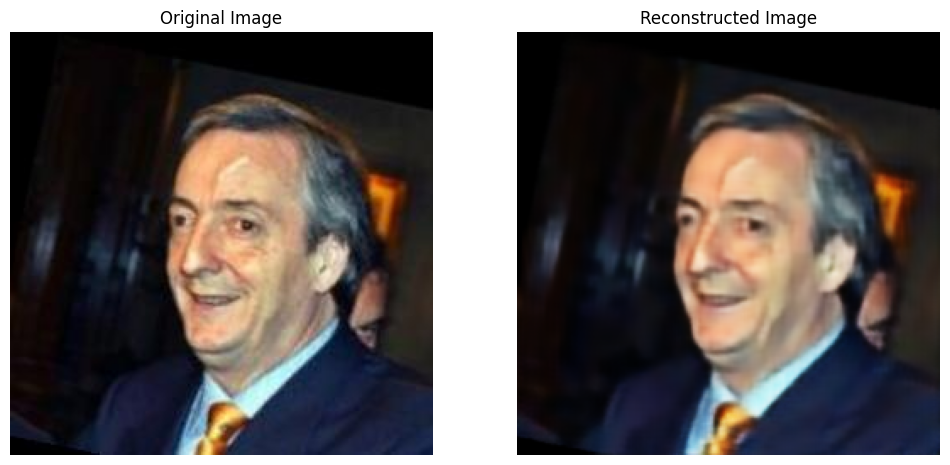

In [22]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Random image selection loop
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Adding a batch dimension and moving the image to the device
input_image = original_image.unsqueeze(0).to(device)
model.eval()
# Forward pass through the autoencoder
with torch.no_grad():
    reconstructed_image = model(input_image)

# Moving the images back to CPU for plotting
original_image_np = original_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()

# Transpose the images
original_image_np = np.transpose(original_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))


# Image Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

To me actually both the image with noise and without noise looked the same. BUt after clearly observing I saw that the noisy image is more smoothed out than the normal image. The features were not clearly visible. When i researched into it I got to know that the purpose of doing it is very desirable. The addition of noise, clearly tells the model that dont rely on some particular features to learn this inturn avoids overfitting.
In my code I added random noise that has mean = 0 and Standard deviation = 1.
0.1 is the scaling factor that determines the amount of noise that I am adding to my image. If we try to increase this value the noisy reconstructed image will smooth out more and that would definitely degrade the quality of the encoded image.

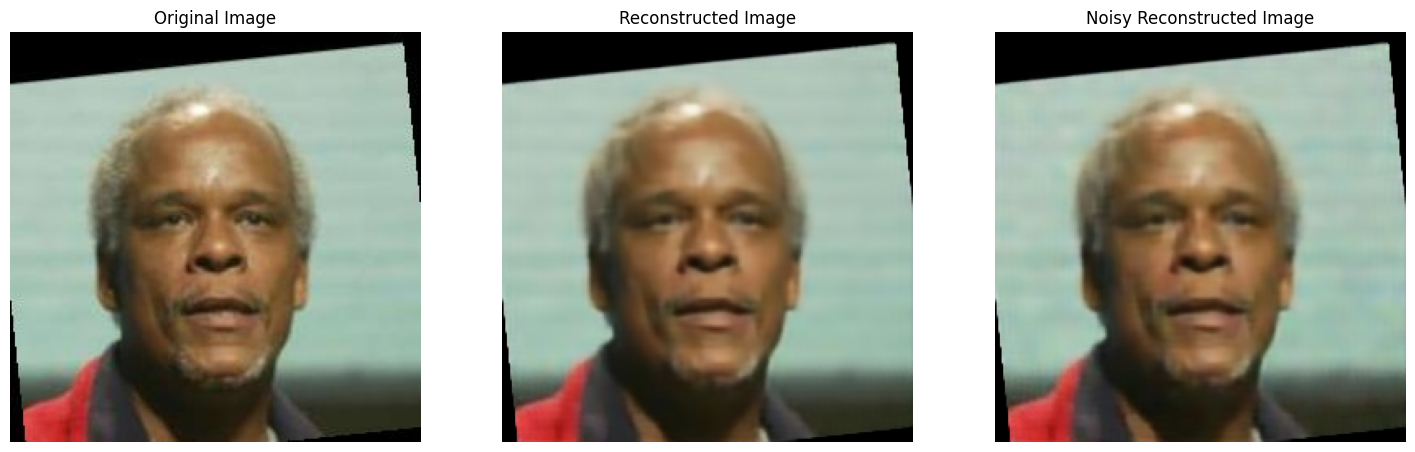

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(dataloader)
images, _ = next(dataiter)

# Taking another random image tp test the addition of noisy data
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]
model.eval()

# Moving the model and image to CUDA  for procesing
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
    original_image = original_image.unsqueeze(0).to(device)

# Adding noise to encoded image
with torch.no_grad():
    encoded_image = model.encoder(original_image)
    noise = torch.randn(encoded_image.shape, device=device) * 0.1
    noisy_encoded = encoded_image + noise

    # Decode
    reconstructed_image = model.decoder(encoded_image)
    noisy_reconstructed_image = model.decoder(noisy_encoded)

# Image back onto CPU
def to_plot(img):
    img = img.squeeze().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    return img

# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(to_plot(original_image))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(to_plot(reconstructed_image))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Noisy Reconstructed Image")
plt.imshow(to_plot(noisy_reconstructed_image))
plt.axis('off')

plt.show()